<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SC-Exploration" data-toc-modified-id="SC-Exploration-2">SC Exploration</a></span></li><li><span><a href="#0.-Imports-&amp;-Data-Loading" data-toc-modified-id="0.-Imports-&amp;-Data-Loading-3">0. Imports &amp; Data Loading</a></span></li><li><span><a href="#1.-Kendall-Tau-Correlation" data-toc-modified-id="1.-Kendall-Tau-Correlation-4">1. Kendall Tau Correlation</a></span></li><li><span><a href="#2.-ICA" data-toc-modified-id="2.-ICA-5">2. ICA</a></span><ul class="toc-item"><li><span><a href="#2.2-Laplacian-matrix" data-toc-modified-id="2.2-Laplacian-matrix-5.1">2.2 Laplacian matrix</a></span></li></ul></li><li><span><a href="#4.-Test" data-toc-modified-id="4.-Test-6">4. Test</a></span><ul class="toc-item"><li><span><a href="#4.1-utils" data-toc-modified-id="4.1-utils-6.1">4.1 utils</a></span></li><li><span><a href="#4.2-Unified-distribution" data-toc-modified-id="4.2-Unified-distribution-6.2">4.2 Unified distribution</a></span></li><li><span><a href="#4.3-Normal-distribution" data-toc-modified-id="4.3-Normal-distribution-6.3">4.3 Normal distribution</a></span></li></ul></li><li><span><a href="#5.-Load-ICA" data-toc-modified-id="5.-Load-ICA-7">5. Load ICA</a></span></li></ul></div>

# SC Exploration

In the following notebook we'll explore the SC dataset.

# 0. Imports & Data Loading

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import sparse
from scipy.fft import fft
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.sparse.csgraph import laplacian
from multiprocessing import Pool, cpu_count

%matplotlib inline

In [2]:
FC_PATH = 'Data/FC/'
SC_PATH = 'Data/SC/'

In [3]:
class Connectome:
    def __init__(self, brain_id):
        self.brain_id = brain_id
        self.FC = pd.read_csv(self._get_fc_path(), header=None)
        self.SC = pd.read_csv(self._get_sc_path(), header=None)
        
    def _get_fc_path(self):
        path = [p for p in os.listdir(FC_PATH) if self.brain_id in p][0]
        return os.path.join(FC_PATH, path)
    
    def _get_sc_path(self):
        path = [p for p in os.listdir(SC_PATH) if self.brain_id in p][0]
        return os.path.join(SC_PATH, path)

In [4]:
brain_ids_sc = [p.split('_')[0] for p in os.listdir(SC_PATH)]
brain_ids_fc = [p.split('_')[0] for p in os.listdir(FC_PATH)]
brain_ids = set(brain_ids_fc).intersection(set(brain_ids_sc))
with open('brain_ids.pkl', 'wb') as f:
    pickle.dump(brain_ids, f, pickle.HIGHEST_PROTOCOL)

In [4]:
with open('brain_ids.pkl', 'rb') as f:
    brain_ids = pickle.load(f)

In [5]:
connectomes = {brain_id : Connectome(brain_id) for brain_id in brain_ids}

<AxesSubplot:>

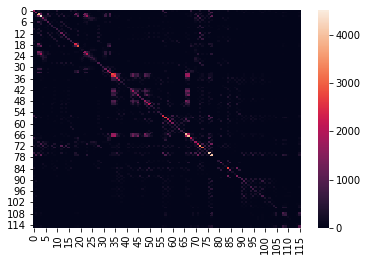

In [6]:
df_sc = pd.read_csv('Data/SC/333001_NH_SC_Matrix_unordered_TH_PA.csv', header=None)
df_fc = pd.read_csv('Data/FC/333001_1_NH_Int_Matrix_PA.csv', header=None)
sns.heatmap(df_sc)

In [7]:
df_sc

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,1843,22,277,52,0,0,127,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22,1595,0,311,0,0,0,48,0,0,...,0,0,138,78,0,0,0,0,0,74
2,277,0,3772,1252,78,33,770,0,100,0,...,0,0,28,0,0,0,0,0,0,29
3,52,311,1252,4518,266,177,267,430,0,38,...,0,0,89,39,0,0,0,0,0,95
4,0,0,78,266,1498,302,0,0,15,0,...,0,0,0,0,0,0,0,0,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,24,64,0,15,0,0
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,24,15,0,24,0,0
114,0,0,0,0,0,0,0,0,0,0,...,0,0,39,75,25,0,0,0,75,65


In [8]:
df_fc

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,125.060,125.13,125.200,125.170,125.050,124.920,124.890,124.960,125.030,125.01,...,125.040,125.160,125.210,125.16,125.090,125.080,125.100,125.090,125.020,124.940
1,121.630,121.71,121.790,121.770,121.650,121.490,121.440,121.520,121.650,121.72,...,121.380,121.340,121.420,121.57,121.720,121.800,121.780,121.680,121.530,121.420
2,120.530,120.61,120.680,120.660,120.550,120.440,120.370,120.320,120.280,120.27,...,120.370,120.480,120.570,120.60,120.610,120.640,120.690,120.680,120.590,120.500
3,119.610,119.75,119.850,119.770,119.550,119.410,119.440,119.560,119.580,119.49,...,119.610,119.770,119.870,119.85,119.770,119.730,119.730,119.720,119.660,119.590
4,57.863,57.84,57.835,57.861,57.874,57.811,57.672,57.533,57.467,57.48,...,57.648,57.709,57.707,57.67,57.666,57.726,57.804,57.829,57.784,57.727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,157.750,157.71,157.680,157.670,157.660,157.630,157.630,157.720,157.890,158.00,...,158.030,157.770,157.360,157.10,157.190,157.590,157.990,158.140,158.010,157.820
112,159.580,159.53,159.530,159.610,159.700,159.730,159.710,159.740,159.880,160.01,...,159.500,159.520,159.400,159.45,159.740,160.040,160.110,159.890,159.570,159.350
113,155.210,155.25,155.350,155.420,155.350,155.140,154.930,154.940,155.180,155.41,...,155.300,155.120,154.990,155.11,155.440,155.700,155.650,155.250,154.710,154.340
114,147.650,147.59,147.510,147.470,147.530,147.690,147.880,147.960,147.820,147.49,...,148.020,147.590,146.970,146.64,146.860,147.400,147.810,147.740,147.280,146.860


# 1. Kendall Tau Correlation 

According to the article, we'll create the Kendall correlation matrix of the FC.

<AxesSubplot:>

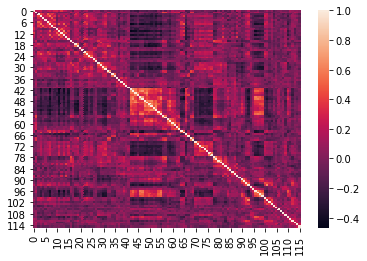

In [9]:
kendall_corrs = df_fc.T.corr(method='kendall')
sns.heatmap(kendall_corrs)

<AxesSubplot:>

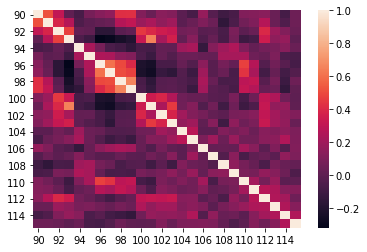

In [10]:
sns.heatmap(kendall_corrs.iloc[90:,90:])

Now let's see if there is a correlation between this matrix and th SC eigenvalues: 

In [11]:
kendall_eigenvalues, kendall_eigenvectors = np.linalg.eig(kendall_corrs)
sc_eigenvalues, sc_eigenvectors = np.linalg.eig(df_sc)
stats.pearsonr(kendall_eigenvalues, sc_eigenvalues)

(0.9488486264484826, 6.563612990730581e-59)

In [12]:
c_f_max = abs(kendall_corrs - np.eye(kendall_corrs.shape[0])).max().max()
tau_mat = kendall_corrs.to_numpy()
tau_mat[abs(tau_mat) < 0.05*c_f_max] = 0
tau_eigenvalues, tau_eigenvectors = np.linalg.eig(tau_mat)
stats.pearsonr(tau_eigenvalues, sc_eigenvalues)

(0.9495939206615133, 2.903580258374818e-59)

0.95 correlation!  
Let's find out if there's a correlation like this for the other subjects:

In [13]:
def get_eigenvectors_corr(fc, sc, method='kendall'):
    tau_mat = fc.T.corr(method=method).to_numpy()
    
    c_f_max = abs(tau_mat - np.eye(tau_mat.shape[0])).max()
    tau_mat[abs(tau_mat) < 0.05*c_f_max] = 0
    
    kendall_eigenvalues, _ = np.linalg.eig(tau_mat)
    sc_eigenvalues, _ = np.linalg.eig(sc)
    return stats.pearsonr(kendall_eigenvalues, sc_eigenvalues)

In [16]:
def get_eigenvectors_corr_wrapper(connectome, method='kendall'):
    return get_eigenvectors_corr(connectome.FC, connectome.SC, method)

In [17]:
correlations = [get_eigenvectors_corr_wrapper(c)[0] for c in tqdm(connectomes.values())]

  0%|          | 0/49 [00:00<?, ?it/s]

In [18]:
corr_vec = np.array(correlations)
print(f'corr mean:{corr_vec.mean()}, corr std:{corr_vec.std()}, corr_vec median:{np.median(corr_vec)}')

corr mean:0.9710269193762859, corr std:0.021903255928531165, corr_vec median:0.9790279347099756


In [20]:
corr_matrix = [[get_eigenvectors_corr(c1.FC, c2.SC)[0] 
                for c1 in connectomes.values()] 
               for c2 in tqdm(connectomes.values())]
corr_matrix = np.array(corr_matrix)

  0%|          | 0/49 [00:00<?, ?it/s]

<AxesSubplot:>

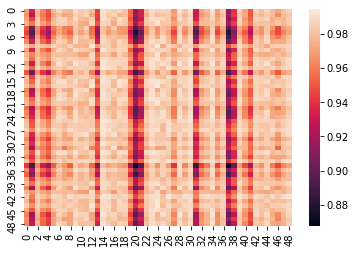

In [21]:
sns.heatmap(corr_matrix)

In [22]:
corr_matrix.diagonal()

array([0.97036447, 0.92738707, 0.98522062, 0.97011736, 0.92518445,
       0.95390461, 0.98224351, 0.98365037, 0.98705115, 0.98953424,
       0.97091797, 0.98250515, 0.97837767, 0.96550897, 0.98278083,
       0.98814521, 0.97902793, 0.99127584, 0.98215849, 0.9474764 ,
       0.91863244, 0.94535123, 0.9728572 , 0.99024452, 0.98690549,
       0.98546995, 0.98982674, 0.98527464, 0.98924243, 0.9750216 ,
       0.99089919, 0.93251495, 0.97689844, 0.97429353, 0.99065082,
       0.94401134, 0.98162537, 0.89209651, 0.94959392, 0.98989585,
       0.96584629, 0.9582978 , 0.98886594, 0.98104711, 0.9792097 ,
       0.97707428, 0.96401387, 0.97717486, 0.98465073])

In [23]:
corr_matrix.diagonal() - corr_matrix.mean(axis=1)

array([-0.00211866, -0.04251285,  0.01274909, -0.00386476, -0.03271668,
        0.00084303,  0.02002362,  0.01505259,  0.00730686,  0.01737564,
       -0.00218865,  0.0034049 ,  0.00471553, -0.01472565,  0.02443583,
        0.00995454,  0.00245611,  0.01274054,  0.01316506, -0.02317394,
       -0.0583841 , -0.02987597,  0.00909666,  0.02227498,  0.01623458,
        0.00694957,  0.01207705,  0.00326279,  0.01365553,  0.0082181 ,
        0.01631046, -0.03603014,  0.00154478,  0.00608602,  0.01076355,
       -0.00759972,  0.01271649, -0.06885074, -0.02182202,  0.01272742,
       -0.0012079 , -0.01498904,  0.00649617,  0.00596921, -0.00047263,
        0.00230886, -0.0039665 ,  0.00851823,  0.01595246])

And let's check for pearson:

In [24]:
correlations_pearson = [get_eigenvectors_corr_wrapper(c, 'pearson')[0] for c in tqdm(connectomes.values())]

  0%|          | 0/49 [00:00<?, ?it/s]

In [25]:
corr_vec_p = np.array(correlations_pearson)
print(f'corr mean:{corr_vec_p.mean()}, corr std:{corr_vec_p.std()}, corr_vec median:{np.median(corr_vec_p)}')

corr mean:0.9697933784070097, corr std:0.02338786997011674, corr_vec median:0.9792104415669468


In [26]:
corr_matrix_p = [[get_eigenvectors_corr(c1.FC, c2.SC, 'pearson')[0] 
                for c1 in tqdm(connectomes.values(), leave=False)] 
               for c2 in tqdm(connectomes.values())]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<AxesSubplot:>

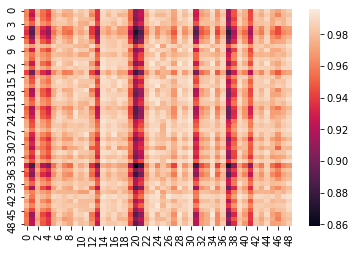

In [27]:
corr_matrix_p = np.array(corr_matrix_p)
sns.heatmap(corr_matrix_p)

In [28]:
corr_matrix_p.diagonal()

array([0.96263511, 0.92282618, 0.98273896, 0.96468422, 0.91818227,
       0.9560492 , 0.98331014, 0.97840655, 0.98281364, 0.99061706,
       0.97105744, 0.98497304, 0.96667022, 0.9603218 , 0.98085075,
       0.98516845, 0.98508158, 0.99310072, 0.98317491, 0.94796454,
       0.91304656, 0.93703091, 0.9680781 , 0.99080288, 0.9851455 ,
       0.98141026, 0.99037375, 0.98731593, 0.99234872, 0.97561568,
       0.99211298, 0.92860416, 0.97921044, 0.97288661, 0.992315  ,
       0.94028785, 0.98197671, 0.89069713, 0.95402016, 0.99188382,
       0.9681662 , 0.95295464, 0.98962029, 0.98063421, 0.98296706,
       0.9748429 , 0.96303765, 0.97687829, 0.98498437])

In [29]:
corr_matrix_p.diagonal() - corr_matrix_p.mean(axis=1)

array([-0.00835389, -0.04502712,  0.01141979, -0.00853951, -0.03713729,
        0.00596646,  0.02320589,  0.01125163,  0.00299952,  0.01969817,
       -0.00131457,  0.00626401, -0.00573417, -0.01924986,  0.02502571,
        0.00807696,  0.00890432,  0.01468274,  0.01557059, -0.02141852,
       -0.06367864, -0.03765893,  0.00642422,  0.02437785,  0.01514034,
        0.003906  ,  0.01383024,  0.00583324,  0.01803387,  0.01116885,
        0.01886128, -0.03815883,  0.00462437,  0.00631921,  0.01324265,
       -0.00862108,  0.01494069, -0.06824759, -0.01538699,  0.01518972,
        0.00314276, -0.01974072,  0.00760206,  0.00665254,  0.00354385,
        0.00071602, -0.00331851,  0.01031322,  0.01775212])

# 2. ICA

In [36]:
glica = pd.read_csv('components_all_regions.csv', header=None)

<AxesSubplot:>

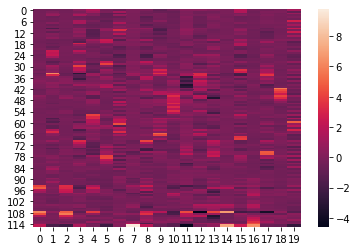

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_ica = scaler.fit_transform(glica)
sns.heatmap(norm_ica)

As described in the article, we shall find the correlation of each ICA component with the eigenvectors of the SC laplacian matrix 

## 2.2 Laplacian matrix

In [71]:
laplacian = sparse.csgraph.laplacian(df_sc.to_numpy()[:90,:90], normed=True)
l_vals, l_vecs = np.linalg.eig(laplacian)

In [72]:
l_idx = l_vals.argsort()[::-1]
l_vals = l_vals[l_idx]
l_vecs = l_vecs[:, l_idx]

In [85]:
ica_laplacian_corr_matrix = [[stats.pearsonr(comp_i, eigvec_j[:90])[0] for eigvec_j in l_vecs] for comp_i in norm_ica[:90].T]

<AxesSubplot:>

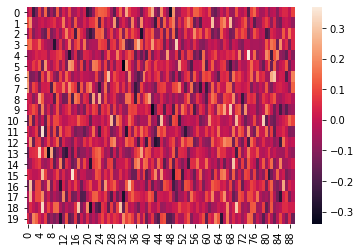

In [86]:
sns.heatmap(ica_laplacian_corr_matrix)

In [87]:
np.array(ica_laplacian_corr_matrix).mean()

0.0018760522911820295

In [91]:
l_vecs[:90, 0].shape

(90,)

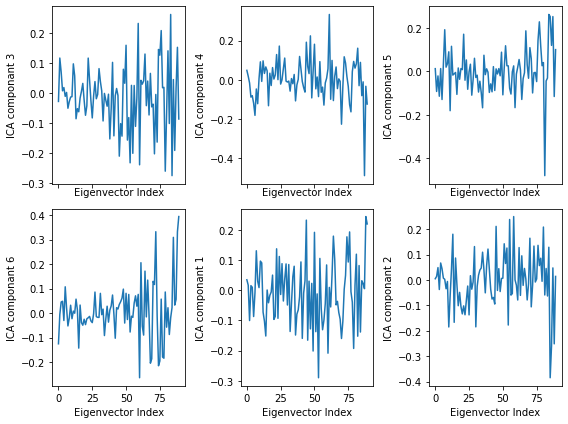

In [93]:
fig, axes = plt.subplots(2,3, sharex=True, figsize=(8,6))
for i in range(6):
    axis_x = (i-2) // 3
    axis_y = (i-2) % 3
    x = np.arange(0,90)
    y = np.array([stats.pearsonr(norm_ica[:90, i], l_vecs[:, j])[0] 
         for j in range(l_vecs.shape[0])])
    
    axes[axis_x, axis_y].plot(x, y)
    axes[axis_x, axis_y].set(xlabel=f'Eigenvector Index', ylabel=f'ICA componant {i+1}')
plt.tight_layout()

In [30]:
tau_mat_90 = df_fc[:90].T.corr(method='kendall').to_numpy()
c_f_max_90 = abs(tau_mat_90 - np.eye(tau_mat_90.shape[0])).max()
tau_mat_90[abs(tau_mat_90) < 0.05*c_f_max_90] = 0
tau_eigenvalues_90, tau_eigenvectors_90 = np.linalg.eig(tau_mat_90)

In [31]:
ica = FastICA(n_components=20)
ica_fc = ica.fit_transform(df_fc[:90])

In [32]:
ica_fc.shape

(90, 20)

IndexError: index 90 is out of bounds for axis 1 with size 90

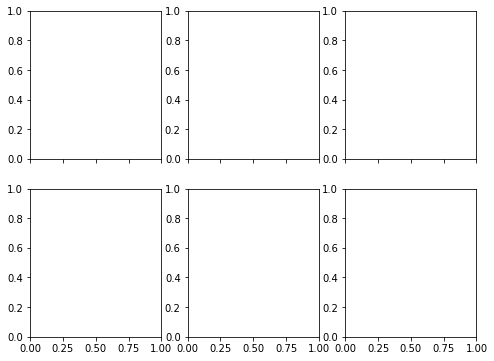

In [33]:
fig, axes = plt.subplots(2,3, sharex=True, figsize=(8,6))
for i in range(2, 8):
    axis_x = (i-2) // 3
    axis_y = (i-2) % 3
    x = np.arange(0,ica_fc.shape[0])
    y = [abs(stats.pearsonr(ica_fc[:, i], tau_eigenvectors_90[:, j])[0]) 
         for j in range(tau_eigenvectors.shape[0])]
    axes[axis_x, axis_y].plot(x, y)
    axes[axis_x, axis_y].set(xlabel=f'Eigenvector Index', ylabel=f'ICA componant {i+1}')
plt.tight_layout()

# 4. Test

Let's check the correlation of random matrix's eig:

## 4.1 utils 

In [ ]:
def get_eig_correlations(a, b, k):
    a_val, a_vec = np.linalg.eig(a)
    a_idx = a_val.argsort()[::-1]
    a_val = a_val[a_idx]
    a_vec = a_vec[:, a_idx]

    b_val, b_vec = np.linalg.eig(b)
    b_idx = b_val.argsort()[::-1]
    b_val = b_val[b_idx]
    b_vec = b_vec[:, b_idx]

    val_corr = stats.pearsonr(a_val, b_val)[0]

    eig_vec_corr_mat = np.array(
        [[stats.pearsonr(a_v, b_v)[0] for b_v in b_vec[-k:]]
         for a_v in a_vec[-k:]])
    diag_corrs = eig_vec_corr_mat.diagonal().mean()
    
    mean_factor = (eig_vec_corr_mat.shape[0] * eig_vec_corr_mat.shape[1]) / (
        eig_vec_corr_mat.shape[0] * eig_vec_corr_mat.shape[1] - k)
    
    mat_corrs = (eig_vec_corr_mat - np.eye(eig_vec_corr_mat.shape[0])* eig_vec_corr_mat.diagonal()).mean() * mean_factor
    
    return val_corr, diag_corrs, mat_corrs

In [ ]:
def generate_matrices(f, shape):
    a = f(shape, shape)
    b = f(shape, shape)
    a = a + a.T
    b = b + b.T
    
    return a, b

In [ ]:
def calc_and_print_correlations(sampling_function, shape, num_of_iterations, k=10, auto=False):
    corrs = []
    diag_corrs = []
    mat_corrs = []
    for i in tqdm(range(num_of_iterations)):
        a,b = generate_matrices(sampling_function, shape)
        if auto:
            b = np.copy(a)

        eig_val_corr, eig_vec_diag_corr, eig_vec_mat_corr = get_eig_correlations(a, b, k=k)
        corrs.append(eig_val_corr)
        diag_corrs.append(eig_vec_diag_corr)
        mat_corrs.append(eig_vec_mat_corr)

    if auto:
        print('Calculations for matrix A with itself:')
        
    print(f'For sampling function {sampling_function.__name__}, sample {num_of_iterations} times:')
    print(f'Eigenvalues correlation mean: {np.array(corrs).mean()}')
    print(f'Top-{k} Eigenvector correlation matrix diagonal mean: {np.array(diag_corrs).mean()}')
    print(f'Top-{k} Eigenvector correlation matrix without diagonal mean: {np.array(mat_corrs).mean()}')

In [ ]:
shape = 116
num_of_iterations = 1000
k = 10

## 4.2 Unified distribution 

In [ ]:
calc_and_print_correlations(np.random.rand, shape, num_of_iterations)

And between a and itself:

In [ ]:
calc_and_print_correlations(np.random.rand, shape, num_of_iterations, auto=True)

## 4.3 Normal distribution 

In [ ]:
calc_and_print_correlations(np.random.randn, shape, num_of_iterations)

And between a and itself:

In [ ]:
calc_and_print_correlations(np.random.randn, shape, num_of_iterations, auto=True)

# 5. Load ICA